In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
import numpy as np
import sympy as sp

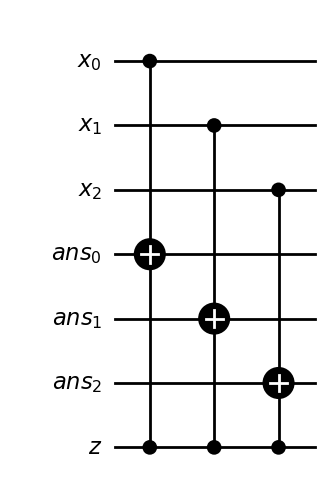

In [2]:
def stateCopy(d):
    x = QuantumRegister(size=d, name="x")
    ans = QuantumRegister(size=d, name="ans")
    z = QuantumRegister(size=1, name="z")
    copyCirc = QuantumCircuit(x, ans, z, name="copyZ")
    
    for i in range(d):
        copyCirc.ccx(x[i], z, ans[i])

    return copyCirc
testCirc = stateCopy(3)
testCirc.draw(output="mpl", style="bw")

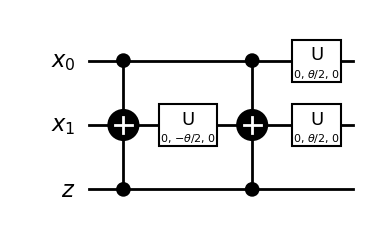

In [3]:
t = Parameter(r"$\theta$")
x = QuantumRegister(size=2, name="x")
z = QuantumRegister(size=1, name="z")
cpDecompose = QuantumCircuit(x, z, name="cpZ")

cpDecompose.ccx(z, x[0], x[1])
cpDecompose.u(0, -t/2, 0, x[1]) # p(theta) == u(0,theta,0)
cpDecompose.ccx(z, x[0], x[1])
cpDecompose.u(0, t/2, 0, x[1])
cpDecompose.u(0, t/2, 0, x[0])

cpDecompose.draw(output="mpl", style="bw")

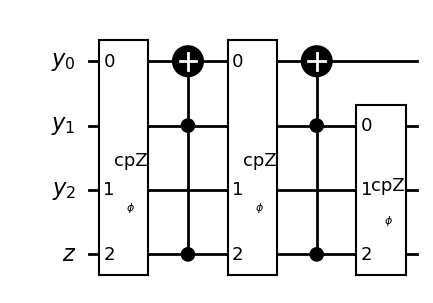

In [4]:
p = Parameter(r"$\phi$")
y = QuantumRegister(size=3, name="y")
ccpDecompose = QuantumCircuit(y, z, name="ccpZ")

cpGate_p = cpDecompose.assign_parameters({t:p/2}).to_gate(label=r'cpZ')
cpGate_n = cpDecompose.assign_parameters({t:-p/2}).to_gate(label=r'cpZ')

ccpDecompose.compose(cpGate_p, qubits=[0, 2, 3], inplace=True)
ccpDecompose.ccx(z, y[1], y[0])
ccpDecompose.compose(cpGate_n, qubits=[0, 2, 3], inplace=True)
ccpDecompose.ccx(z, y[1], y[0])
ccpDecompose.compose(cpGate_p, qubits=[1, 2, 3], inplace=True)

ccpDecompose.draw(output="mpl", style="bw")

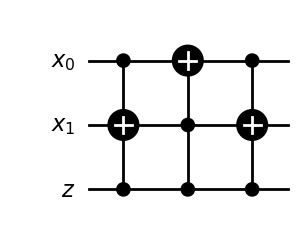

In [5]:
swapDecompose = QuantumCircuit(x, z, name='swapZ')

swapDecompose.ccx(z, x[0], x[1])
swapDecompose.ccx(z, x[1], x[0])
swapDecompose.ccx(z, x[0], x[1])

swapDecompose.draw(output="mpl", style="bw")

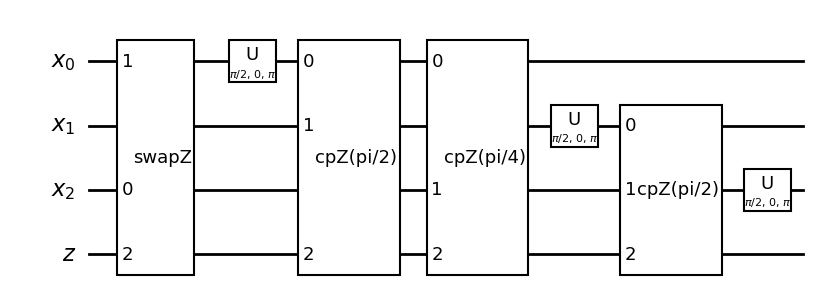

In [6]:
def qftDecompose(n): # |x1x2...xn> => |F(x1)F(x2)...F(xn)>
    x = QuantumRegister(size=n, name="x")
    z = QuantumRegister(size=1, name="z")
    qftCirc = QuantumCircuit(x, z, name='qftZ')

    for q, p in zip(x[:n >> 1], reversed(x[n >> 1:])):
        swapGate = swapDecompose.to_gate()
        qftCirc.compose(swapGate, qubits=[p, q, n], inplace=True)

    for i, q in enumerate(x, start=1):
        qftCirc.u(np.pi/2, 0, np.pi, q) # h == u(pi/2,0,pi)
        for j, p in enumerate(x[i:], start=1):
            cpGate = cpDecompose.assign_parameters({t:np.pi/(1<<j)}).to_gate(label='cpZ({})'.format(sp.pi/(1<<j)))
            qftCirc.compose(cpGate, qubits=[q, p, n], inplace=True)

    return qftCirc

testCirc = qftDecompose(3)
testCirc.draw(output="mpl", style="bw")

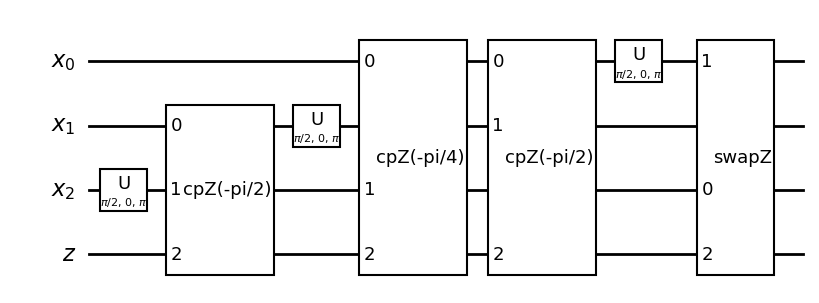

In [7]:
def iqftDecompose(n): # |F(a1)F(a2)...F(an)> => |a1a2...an>
    x = QuantumRegister(size=n, name="x")
    z = QuantumRegister(size=1, name="z")
    iqftCirc = QuantumCircuit(x, z, name='iqftZ')

    for i, q in enumerate(reversed(x), start=1):
        for j, p in enumerate(reversed(x[n + 1 - i:]), start=1):
            cpGate = cpDecompose.assign_parameters({t:-np.pi/(1<<(i-j))}).to_gate(label='cpZ({})'.format(-sp.pi/(1<<(i-j))))
            iqftCirc.compose(cpGate, qubits=[q, p, n], inplace=True)
        iqftCirc.u(np.pi/2, 0, np.pi, q)

    for q, p in zip(x[:n >> 1], reversed(x[n >> 1:])):
        swapGate = swapDecompose.to_gate()
        iqftCirc.compose(swapGate, qubits=[p, q, n], inplace=True)

    return iqftCirc

testCirc = iqftDecompose(3)
testCirc.draw(output="mpl", style="bw")

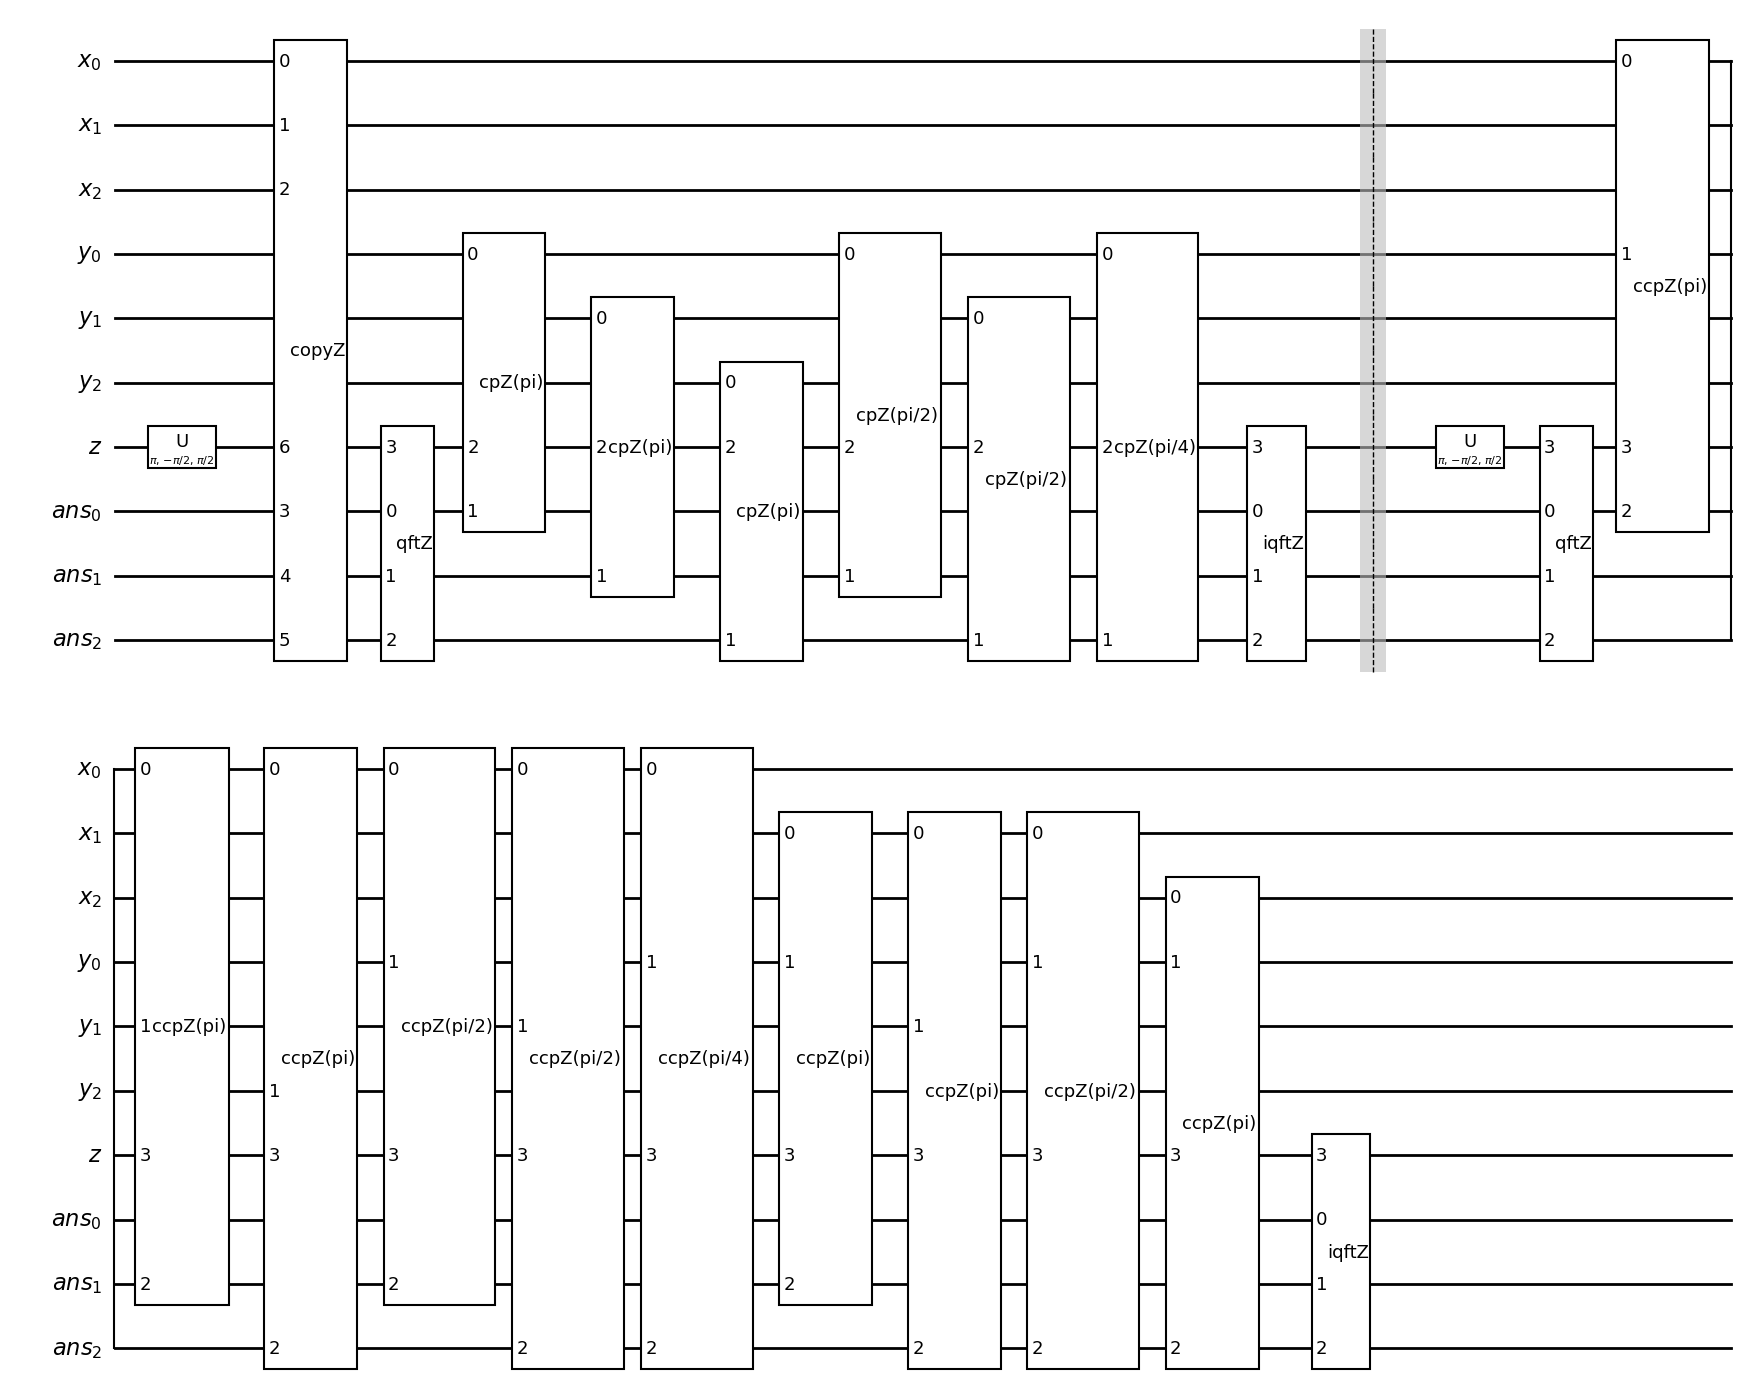

In [8]:
def calc(d):
    x = QuantumRegister(size=d, name="x")
    y = QuantumRegister(size=d, name="y")
    z = QuantumRegister(size=1, name="z")
    ans = QuantumRegister(size=d, name="ans"); arange = range(2*d+1,3*d+1)
    circ = QuantumCircuit(x, y, z, ans, name='{}-digit calculator'.format(d))

    circ.u(np.pi, -np.pi/2, np.pi/2, z) # NOT z, in order to control addition
    copyGate = stateCopy(d).to_gate()
    circ.compose(copyGate, qubits=list(range(d))+list(arange)+[2*d], inplace=True)
    qftGate = qftDecompose(d).to_gate()
    circ.compose(qftGate, qubits=list(arange)+[2*d], inplace=True)
    for i in range(d): # index for rotation angle
        for j in range(i,d): # index for ans
            cpGate = cpDecompose.assign_parameters({t:2*np.pi/2**(i+1)}).to_gate(label='cpZ({})'.format(2*sp.pi/2**(i+1)))
            circ.compose(cpGate, qubits=[d+j-i, 2*d+1+j, 2*d], inplace=True)
    iqftGate = iqftDecompose(d).to_gate()
    circ.compose(iqftGate, qubits=list(arange)+[2*d], inplace=True)

    circ.barrier()

    circ.u(np.pi, -np.pi/2, np.pi/2, z) # now comes the multiplication
    qftGate = qftDecompose(d).to_gate()
    circ.compose(qftGate, qubits=list(arange)+[2*d], inplace=True)
    for k in range(d): # index for x, adding 2^k|y_k> to ans when x_k==1
        for i in range(d): # index for rotation angle
            for j in range(i+k,d): # index for ans, where 2^k|y_k> is all-zero for indices 0 through k-1
                ccpGate = ccpDecompose.assign_parameters({p:2*np.pi/2**(i+1)}).to_gate(label='ccpZ({})'.format(2*sp.pi/2**(i+1)))
                circ.compose(ccpGate, qubits=[k, d+j-i-k, 2*d+1+j, 2*d], inplace=True)
    iqftGate = iqftDecompose(d).to_gate()
    circ.compose(iqftGate, qubits=list(arange)+[2*d], inplace=True)

    return circ
testCirc = calc(3)
testCirc.draw(output="mpl", style="bw")

A simple way to verify if z acts as a controller correctly is to commentate '#' before every '.to_gate(' and observe there are only dots (control notation) on this line.